In [1]:
# Tested with abtem version 1.0.0beta8
from abtem import __version__
print('Current abtem version:', __version__)

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# ASE: Atomic Simulation Environment
import ase
from ase import Atoms
from ase.io import read
from ase.build import bulk  # or other relevant builders if used
from ase.cluster import wulff_construction
from ase.visualize import view
from ase.geometry import cellpar_to_cell, cell_to_cellpar

# abTEM: Atomic-resolution TEM image simulation
import abtem
from abtem import * 

Current abtem version: 1.0.6


## 读取结构

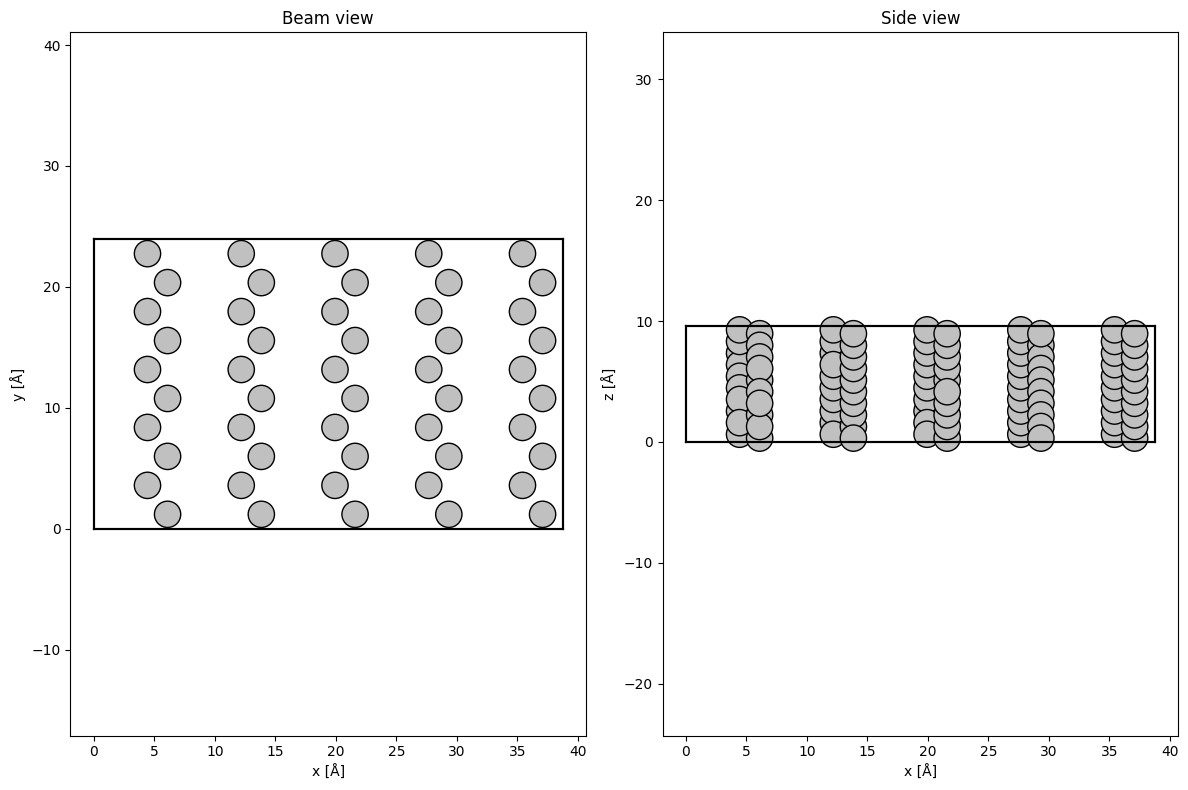

In [54]:
structure = ase.io.read('cif/Ag/1509145.cif', format='cif')
surface = ase.build.surface(structure, indices=(1, 2, 0), layers = 1, periodic=True)

#长宽高
length = 5
width = 5
height = 10
repeated_surface = surface * (length, width, height)

# 旋转一定的角度
# 计算表面中心点
center_of_mass = repeated_surface.get_center_of_mass()
# 旋转矩阵
angle = 0  # degrees
theta = np.radians(angle)
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]])
# 旋转所有原子位置
positions = repeated_surface.get_positions()
# 将原子位置移动到中心点
positions -= center_of_mass
# 应用旋转矩阵
rotated_positions = positions.dot(rotation_matrix.T)
# 将原子位置移回原位
rotated_positions += center_of_mass
repeated_surface.set_positions(rotated_positions)
# 去除超出边界的原子
for atom in reversed(repeated_surface):
    x, y, z = atom.position
    if x < 0 or x > length * surface.cell.lengths()[0] or \
       y < 0 or y > width * surface.cell.lengths()[1]:
        del repeated_surface[atom.index]

#可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
abtem.show_atoms(repeated_surface, ax=ax1, title="Beam view")
abtem.show_atoms(repeated_surface, ax=ax2, plane="xz", title="Side view")
fig.tight_layout();

# Configuration
We start by (optionally) setting our configuration. See documentation for details.

In [42]:
abtem.config.set({"device": "gpu", "fft": "fftw"})

# Potential
We create an ensemble of potentials using the frozen phonon model. See our walkthrough on frozen phonons.

In [43]:
frozen_phonons = abtem.FrozenPhonons(repeated_surface, 16, sigmas=0.1)

We create a potential from the frozen phonons model, see walkthrough on potentials.

In [44]:
potential = abtem.Potential(
    frozen_phonons,
    sampling=0.04,
    parametrization='lobato',
    projection="finite",
    slice_thickness=1,
)

# Wave function
We create a plane wave function at an energy of 100 keV. See our walkthrough on wave functions.

In [45]:
wave = abtem.PlaneWave(energy=100e3)

# Multislice
We run the multislice algorithm to calculate the exit waves, see our walkthrough on multislice.

In [46]:
exit_wave = wave.multislice(potential)

In [47]:
exit_wave.compute()

[########################################] | 100% Completed | 15.22 s


# Contrast transfer function
We create a contrast transfer function of the objective lens, see our walkthrough on the contrast transfer function

In [48]:
Cs = -7e-6 * 1e10  # spherical aberration (-8 um)

ctf = abtem.CTF(Cs=Cs, energy=wave.energy, defocus="scherzer", semiangle_cutoff=50)

print(f"defocus = {ctf.defocus:.2f} Å")

defocus = -62.34 Å


We include partial coherence in the quasi-coherent approximation. For more accurate descriptions of partial coherence, see our tutorial on partial coherence.

In [49]:
Cc = 1e-3 * 1e10  # chromatic aberration (1.2 mm)
energy_spread = 0.35  # standard deviation energy spread (0.35 eV)

focal_spread = Cc * energy_spread / exit_wave.energy

incoherent_ctf = ctf.copy()
incoherent_ctf.focal_spread = focal_spread

We show a profiles of the contrast transfer functions.

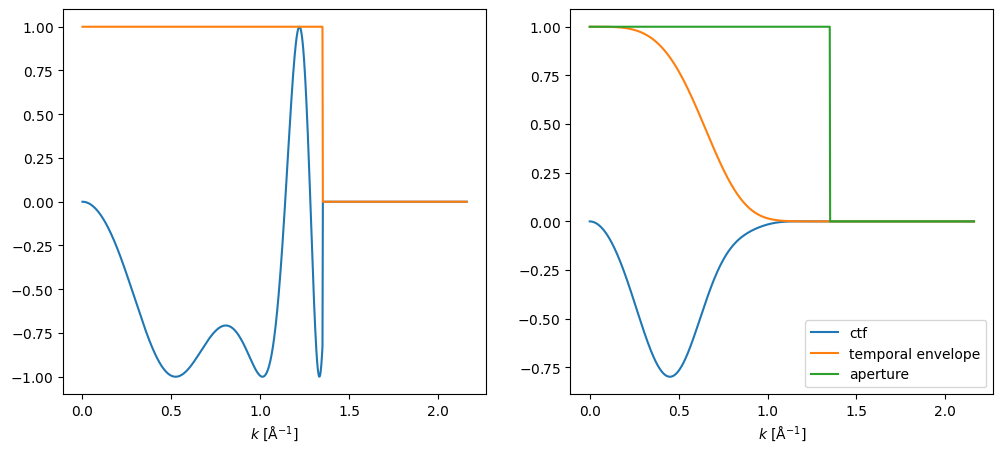

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ctf.profiles().show(ax=ax1)
incoherent_ctf.profiles().show(ax=ax2, legend=True);

We apply the contrast transfer function, then calculate the intensities of the wave functions.

In [51]:
measurement_ensemble = exit_wave.apply_ctf(incoherent_ctf).intensity()

measurement_ensemble.shape

(16, 970, 599)

The result is an ensemble of images, one for each frozen phonon, we average the ensemble to obtain the final image.

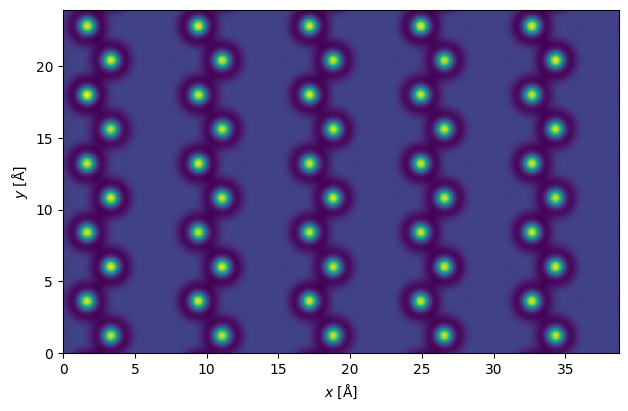

In [52]:
measurement = measurement_ensemble.mean(0)

measurement.show()

# Postprocessing
Many tasks requires additional post-processing steps. Below we apply Poisson noise to simulate the shot noise of a given finite electron dose.

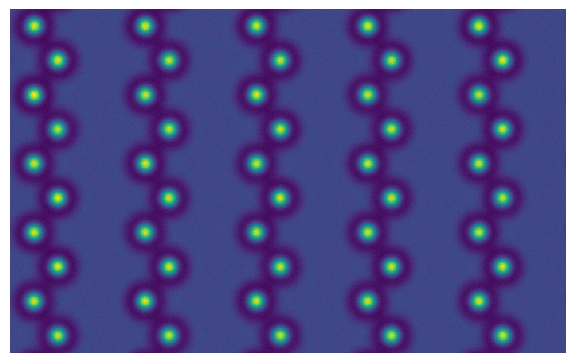

In [53]:
noise = 1e6
noisy_measurement = measurement.poisson_noise(dose_per_area = noise)

visualization = noisy_measurement.show()

plt.axis('off')

#存储路径
save_path_temp = f'temp.png'
save_path = f'output_hrtem.jpg'

plt.savefig(save_path_temp, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

#重新读取并调整
read_image = Image.open(save_path_temp).convert('L')
read_image = read_image
read_image.save(save_path)